# Training a Model

Now that we've got data in Hopsworks and the architecture for updating it, we can go ahead and start writing our model training data. Since we're working with time series data that has strong seasonality, I'm going to use Meta's Prophet algorithm.

Since our data is hosted on Hopsworks, we need to get it:

In [1]:
import hopsworks

project = hopsworks.login()

fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/14486
Connected. Call `.close()` to terminate connection gracefully.


In [2]:
# Load feature groups.
zip_code = '60603'  # Chicago
country_code = 'US'
city = 'Chicago'

fg_name = f'aqi_{city}_{zip_code}'.lower()

aqi_online_fg = fs.get_feature_group(fg_name, version=1)

not_features = ['date', 'lat', 'lon']

ds_query = aqi_online_fg.select_except(not_features)

In [3]:
ds_query.show(5, online=True)

,co,no,no2,o3,so2,pm2_5,pm10,nh3,datetime,aqi,id
0,230.31,0.00,8.23,70.81,3.37,0.78,1.96,0.47,2020-11-30 08:00:00,1,80
1,1041.41,85.83,71.29,0.00,10.01,47.22,71.06,2.72,2020-12-08 02:00:00,4,266
2,297.07,0.05,22.96,41.84,4.17,5.59,7.95,2.38,2020-12-13 23:00:00,1,407
3,333.79,7.15,20.22,26.11,8.46,8.83,11.68,1.33,2020-12-21 12:00:00,1,588
4,330.45,0.06,30.16,38.62,5.66,14.31,17.61,1.36,2020-12-27 20:00:00,2,740


Notice that the data appears to be out of order. This is ok.

We will now define some transformation functions to normalize all of our features. These transformations will be applied to the data when we create a feature view.

In [4]:
# Load the transformation function we want.
standard_scaler = fs.get_transformation_function(name="standard_scaler")

# Map features to transformation function
transformation_functions = {
    'co': standard_scaler, 
    'no': standard_scaler, 
    'no2': standard_scaler, 
    'o3': standard_scaler,
    'so2': standard_scaler, 
    'pm2_5': standard_scaler, 
    'pm10': standard_scaler, 
    'nh3': standard_scaler
}

Training data is created from feature views in Hopsworks. Feature views are logical views over sets of features. Normally they are created by joining together different feature groups. Since we only have one here though it's a little different.

In [5]:
fv_name = f'{fg_name}_fv'

try:
    feature_view = fs.get_feature_view(name=fv_name, version=1)
except: 
    feature_view = fs.create_feature_view(
    name=fv_name,
    version=1,
    description='feature view for creating training data',
    query=ds_query,
    labels=['aqi', 'id'],  # not using ID as a label, just for keeping track of data order
    transformation_functions=transformation_functions
)

Now let's get the earliest and latest dates in the dataset to split our data into a training and testing set:

In [6]:
import datetime
import pandas as pd

end_date = pd.to_datetime(fs.sql(f"SELECT MAX(`datetime`) FROM `{fg_name}_1`", online=True).values[0][0])
start_date = pd.to_datetime(fs.sql(f"SELECT MIN(`datetime`) FROM `{fg_name}_1`", online=True).values[0][0])

print(start_date, end_date)

2020-11-27 00:00:00 2023-01-19 14:00:00


In [7]:
start_date_str = start_date.strftime('%Y-%m-%d %H:%M:%S')
end_date_str = end_date.strftime('%Y-%m-%d %H:%M:%S')

print(start_date_str, end_date_str)

2020-11-27 00:00:00 2023-01-19 14:00:00


In [8]:
# # Create training datasets based event time filter
# train_d, train_d_job = feature_view.create_training_data(
#         start_time = start_date_str,
#         end_time = end_date_str,    
#         description = f'aqi data for training {start_date_str} to {end_date_str}',
#         data_format = "csv",
#         coalesce = True,
#         write_options = {'wait_for_job': False},
#     )

We're going to use the training data for validation as well. Scikit-Learn has convenient functions for splitting time series data into validation sets, so that is why I'm not doing it via Hopsworks. Now that the train and test data set views have been created, we can access them like so:

In [9]:
train_x, train_y = feature_view.get_training_data(1)

In [10]:
train_x.head()

,co,no,no2,o3,so2,pm2_5,pm10,nh3,datetime
0,-0.791461,-0.293499,-1.056092,0.726840,-1.063491,-0.855125,-0.827553,-0.740341,2021-05-08T18:00:00.000Z
1,-0.610748,-0.315214,-0.533651,0.087571,-0.654927,-0.753689,-0.697906,-0.496950,2021-05-08T06:00:00.000Z
2,-0.645147,-0.315214,-0.653637,0.170039,-0.809822,-0.764770,-0.722633,-0.580878,2021-05-08T05:00:00.000Z
3,-0.713998,-0.315214,-0.850615,0.458964,-0.949003,-0.806538,-0.789461,-0.706770,2021-05-08T02:00:00.000Z
4,-0.627922,-0.315214,-0.610642,0.293741,-0.836761,-0.786080,-0.730652,-0.585075,2021-05-08T00:00:00.000Z


Now we have a dataframe for each train and test x and y! Simple!

In [11]:
# check that we have the right time period for train and test
print(train_x['datetime'].min(), train_x['datetime'].max())

2020-11-27T12:00:00.000Z 2023-01-19T02:00:00.000Z


In [12]:
train_x.dtypes

co          float64
no          float64
no2         float64
o3          float64
so2         float64
pm2_5       float64
pm10        float64
nh3         float64
datetime     object
dtype: object

In [13]:
# need to convert datetime from strings
train_x.datetime = pd.to_datetime(train_x.datetime)

In [14]:
train_x.head()

,co,no,no2,o3,so2,pm2_5,pm10,nh3,datetime
0,-0.791461,-0.293499,-1.056092,0.726840,-1.063491,-0.855125,-0.827553,-0.740341,2021-05-08 18:00:00+00:00
1,-0.610748,-0.315214,-0.533651,0.087571,-0.654927,-0.753689,-0.697906,-0.496950,2021-05-08 06:00:00+00:00
2,-0.645147,-0.315214,-0.653637,0.170039,-0.809822,-0.764770,-0.722633,-0.580878,2021-05-08 05:00:00+00:00
3,-0.713998,-0.315214,-0.850615,0.458964,-0.949003,-0.806538,-0.789461,-0.706770,2021-05-08 02:00:00+00:00
4,-0.627922,-0.315214,-0.610642,0.293741,-0.836761,-0.786080,-0.730652,-0.585075,2021-05-08 00:00:00+00:00


In [15]:
# data points are not in order
train_x = train_x.sort_values("datetime")
train_y = train_y.reindex(train_x.index)

In [16]:
print(train_x['datetime'].min(), train_x['datetime'].max())

2020-11-27 12:00:00+00:00 2023-01-19 02:00:00+00:00


In [17]:
# need to remove time zone information
train_x['datetime'] = train_x['datetime'].dt.tz_localize(None)

In [18]:
print(train_x['datetime'].min(), train_x['datetime'].max())

2020-11-27 12:00:00 2023-01-19 02:00:00


In [19]:
# use the datetime as index now
train_x = train_x.reset_index(drop=True)
train_x = train_x.set_index('datetime')

In [20]:
train_y = train_y.reset_index(drop=True)
train_y = train_y.set_index(train_x.index)
train_y['aqi'] = train_y['aqi']-1  # xgboost requires zero indexed categories for classification

In [21]:
train_x.tail()

,co,no,no2,o3,so2,pm2_5,pm10,nh3
datetime,,,,,,,,
2023-01-18 22:00:00,-0.524671,-0.313699,-0.645138,-0.273441,-0.702069,-0.752836,-0.756047,-0.660610
2023-01-18 23:00:00,-0.421369,-0.312184,-0.525152,-0.572458,-0.729008,-0.685496,-0.703921,-0.652217
2023-01-19 00:00:00,-0.352519,-0.312184,-0.593644,-0.592931,-1.007370,-0.682939,-0.709267,-0.669003
2023-01-19 01:00:00,-0.369744,-0.313699,-0.735128,-0.500083,-1.029818,-0.742608,-0.768076,-0.706770
2023-01-19 02:00:00,-0.369744,-0.314204,-0.747627,-0.407523,-0.955738,-0.740903,-0.766739,-0.706770


In [22]:
train_y.tail()

,aqi,id
datetime,,
2023-01-18 22:00:00,0,18596
2023-01-18 23:00:00,0,18597
2023-01-19 00:00:00,0,18598
2023-01-19 01:00:00,0,18599
2023-01-19 02:00:00,0,18600


In [62]:
# concat
train = pd.concat([train_x, train_y], axis=1)
train = train.drop(columns=['id'])

In [63]:
train.head()

,co,no,no2,o3,so2,pm2_5,pm10,nh3,aqi
datetime,,,,,,,,,
2020-11-27 12:00:00,0.886949,1.028102,1.068668,-1.451633,2.207264,0.752517,0.962775,0.329741,1
2020-11-27 13:00:00,0.852498,1.073048,1.068668,-1.463167,2.422770,0.747403,0.934039,0.346526,1
2020-11-27 14:00:00,0.370491,0.322609,0.760203,-1.124069,1.271159,0.616984,0.643336,-0.052132,1
2020-11-27 15:00:00,0.095088,0.079701,0.245761,-0.675399,0.575254,0.503614,0.449534,-0.140256,1
2020-11-27 16:00:00,-0.042665,-0.047056,0.108776,-0.479610,0.388931,0.311822,0.251054,-0.102489,1


## Modeling with XGBoost

We have our training and testing data all set up, and now we can use a model to predict future values of the AQI. Originally, I was going to use Prophet for this task. However, Prophet was constantly underfitting the data and the mechanisms for adding regressor was weird. I have many features available to use for prediction. In addition, because my target variable is integral on a range of 1 to 5, I am going to pose this as a classification task. Prophet does not support classification.

Alright, so we need to do a little bit of preprocessing. We'll make some cross validation folds so that we can find the best model. After training, I'll write a function to compute some lag features so that we can make predictions into the future.

In [64]:
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

In [65]:
tss = TimeSeriesSplit(n_splits=3, test_size=24*90*1, gap=24)

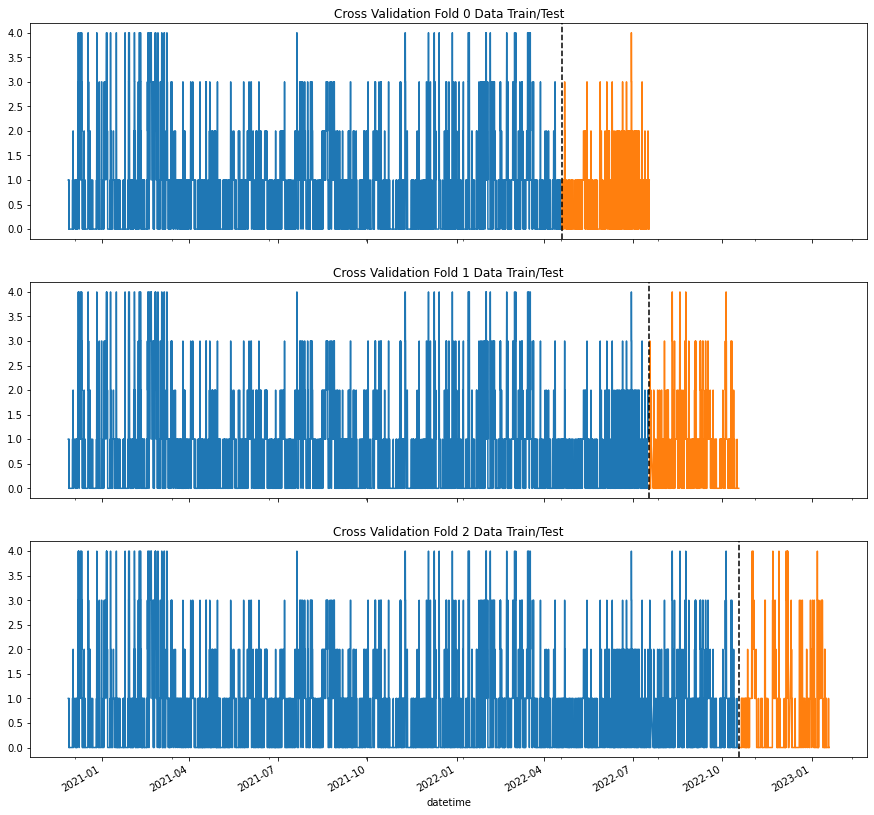

In [66]:
fig, axs = plt.subplots(3, 1, figsize=(15,15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(train):
    train_val = train.iloc[train_idx]
    test_val = train.iloc[val_idx]
    train_val['aqi'].plot(ax=axs[fold], 
                          label='Training Set', 
                          title=f'Cross Validation Fold {fold} Data Train/Test')
    test_val['aqi'].plot(ax=axs[fold], 
                          label='Test Set')
    axs[fold].axvline(test_val.index.min(), color='black', ls='--')
    fold += 1    

### Forecasting Horizon

We're going to be predicting data 3 days into the future. Thus our forecasting horizon will be 3 days.

In [67]:
def add_lags(df: pd.DataFrame) -> pd.DataFrame:
    target_map = df['aqi'].to_dict()
    df['lag3'] = (df.index - pd.Timedelta('3 days')).map(target_map)
    return df

In [68]:
df = add_lags(train).copy()

In [69]:
df['aqi'].value_counts()

0    8855
1    7034
2    1363
3    1088
4     249
Name: aqi, dtype: int64

## Training XGBoost

In [70]:
import xgboost as xgb
from sklearn.metrics import log_loss

In [77]:
fold = 0
preds = []
scores = []

In [78]:
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    features = ['co', 'no', 'no2', 'o3', 'so2', 'pm2_5', 'pm10', 'nh3', 'lag3']
    target = 'aqi'
    
    x_train = train[features]
    y_train = train[target]
    
    x_test = test[features]
    y_test = test[target]
    
    clf = xgb.XGBClassifier(n_estimators=1000, 
                            booster='gbtree',
                            early_stopping_rounds=50,
                            max_depth=3,
                            learning_rate=0.05)
    clf.fit(x_train, y_train,
            eval_set=[(x_train, y_train), (x_test, y_test)],
            verbose=10)
    
    y_pred = clf.predict_proba(x_test)
    preds.append(y_pred)
    score = log_loss(y_test, y_pred)
    scores.append(score)

[0]	validation_0-mlogloss:1.48683	validation_1-mlogloss:1.48698
[10]	validation_0-mlogloss:0.77410	validation_1-mlogloss:0.77534
[20]	validation_0-mlogloss:0.44345	validation_1-mlogloss:0.44529
[30]	validation_0-mlogloss:0.26199	validation_1-mlogloss:0.26435
[40]	validation_0-mlogloss:0.15709	validation_1-mlogloss:0.15982
[50]	validation_0-mlogloss:0.09517	validation_1-mlogloss:0.09814
[60]	validation_0-mlogloss:0.05861	validation_1-mlogloss:0.06169
[70]	validation_0-mlogloss:0.03654	validation_1-mlogloss:0.03983
[80]	validation_0-mlogloss:0.02306	validation_1-mlogloss:0.02662
[90]	validation_0-mlogloss:0.01488	validation_1-mlogloss:0.01867
[100]	validation_0-mlogloss:0.00981	validation_1-mlogloss:0.01381
[110]	validation_0-mlogloss:0.00669	validation_1-mlogloss:0.01088
[120]	validation_0-mlogloss:0.00469	validation_1-mlogloss:0.00895
[130]	validation_0-mlogloss:0.00341	validation_1-mlogloss:0.00769
[140]	validation_0-mlogloss:0.00258	validation_1-mlogloss:0.00683
[150]	validation_0-ml

In [79]:
scores

[0.004696813281434178, 0.0072303198238202, 0.453182144973565]

In [80]:
preds = clf.predict(x_train)

In [81]:
preds = pd.DataFrame({'aqi': preds}, index=x_train.index)

In [ ]:
preds

In [ ]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(y_train['aqi'],preds['aqi'])

In [ ]:
import seaborn as sns
sns.heatmap(cf, annot=True)

In [ ]:
x_test = test_x.reset_index(drop=True)
x_test = x_test.set_index('datetime')

y_test = test_y[['aqi']]
y_test = y_test.reset_index(drop=True)
y_test = y_test.set_index(x_test.index)
y_test['aqi'] = y_test['aqi']-1


preds = clf.predict(x_test)
preds = pd.DataFrame({'aqi': preds}, index=x_test.index)

cf = confusion_matrix(y_test['aqi'], preds['aqi'])
sns.heatmap(cf, annot=True)